<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/artificial-intelligence/rbf-stock-prec/rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
cols = [ "Date", "Close" ]
tsla_data = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/statistics/stock-price-pred/res/tsla_2yr_data.csv", usecols=cols)
tsla_data = tsla_data[:450]
tsla_data.head()

,Date,Close
0,2019-11-25,67.267998
1,2019-11-26,65.783997
2,2019-11-27,66.258003
3,2019-11-29,65.987999
4,2019-12-02,66.973999


In [3]:
tsla_data.describe()

,Close
count,450.000000
mean,433.907786
std,252.867234
min,65.783997
25%,161.976002
50%,425.855011
75%,667.444992
max,883.090027


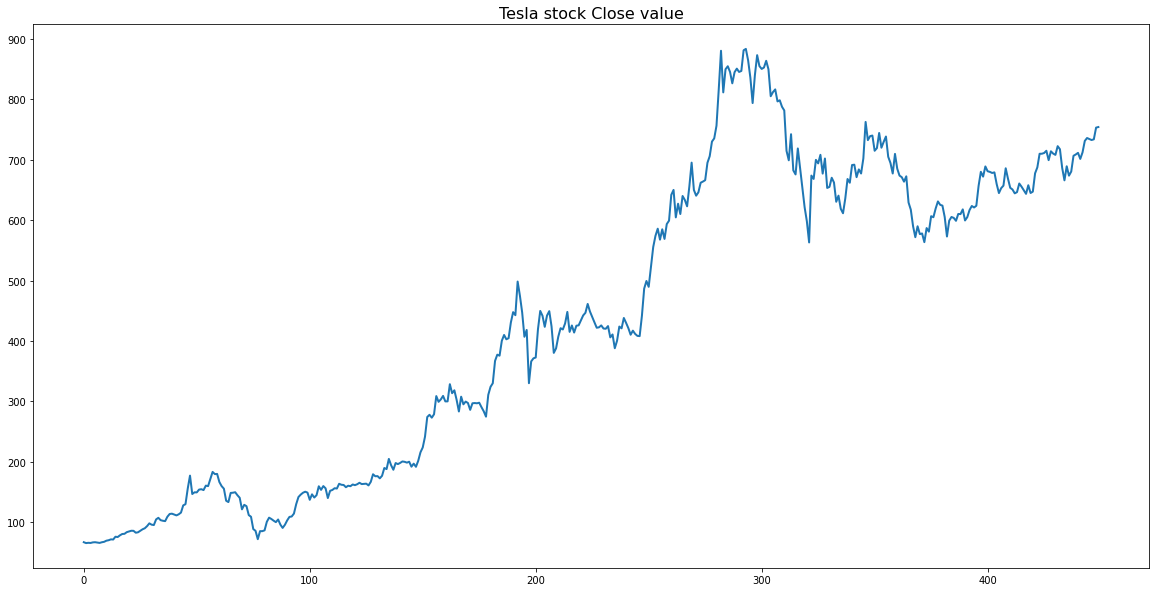

In [4]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(tsla_data.Close, linewidth=2)
plt.show()

In [25]:
max = tsla_data.Close.max()
data = pd.DataFrame({'val': tsla_data.Close / max})
data.describe()

,val
count,450.000000
mean,0.491352
std,0.286344
min,0.074493
25%,0.183420
50%,0.482233
75%,0.755806
max,1.000000


In [68]:
def segment_data(data, train_ratio):
    separation_point = int(np.floor(len(data) * train_ratio))
    return (data[:separation_point], data[separation_point:], separation_point)

(train_data, test_data, seg) = segment_data(list(data.val), .8)

len(train_data)

360

In [69]:
np.array(train_data)

array([0.07617343, 0.07449297, 0.07502973, 0.07472398, 0.07584051,
       0.07614172, 0.0754238 , 0.07482136, 0.07607152, 0.0768959 ,
       0.0790044 , 0.07987861, 0.08145942, 0.08116726, 0.08640116,
       0.08583269, 0.08903962, 0.09150596, 0.091857  , 0.09494389,
       0.09630955, 0.09759821, 0.09747137, 0.09392021, 0.09474232,
       0.0974442 , 0.10033178, 0.10226364, 0.10623152, 0.11145863,
       0.10901267, 0.1082902 , 0.11886897, 0.12182676, 0.11742857,
       0.11629392, 0.11561675, 0.12392848, 0.12899251, 0.12959041,
       0.127919  , 0.12637896, 0.12839008, 0.13158115, 0.14512903,
       0.14733945, 0.17665243, 0.20089911, 0.166393  , 0.16962258,
       0.169421  , 0.17467754, 0.17537964, 0.17377389, 0.18208789,
       0.18118877, 0.19440826, 0.20777496, 0.20369611, 0.2040562 ,
       0.18883465, 0.18116159, 0.17638065, 0.15377821, 0.1512847 ,
       0.16841318, 0.16884123, 0.16974486, 0.164092  , 0.15932237,
       0.1376983 , 0.1461527 , 0.14363881, 0.12695195, 0.12379

In [65]:
train_data = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ])
train_data

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [92]:
class RBF():
    def __init__(self, train_data, pred_win=1, learn_rate=.2):
        self.train_data = train_data
        self.pred_win = pred_win
        self.hidden_dim = len(train_data)-pred_win

        self.learning_rate = learn_rate

        self.G = np.zeros(self.hidden_dim)
        self.W = 2 * np.random.random(self.hidden_dim) - 1
        self.Xi = [ train_data[i:i+self.pred_win] for i in range(0, self.hidden_dim) ]


    def g(self, x, xi):
        return np.exp(-np.power(np.linalg.norm(x-xi), 2))


    def compute(self, x):
        if len(x) != self.pred_win:
            raise Exception("Input vector dim invalid")
        self.G = np.array([ self.g(x, np.array(self.Xi[i])) for i in range(self.hidden_dim) ])
        return np.sum(np.multiply(self.G, self.W))


    def update(self, error):
        for i in range(self.hidden_dim):
            deltaW = self.learning_rate * self.G[i] * error
            self.W[i] += deltaW


    def fit(self, iters=100):
        for i in range(iters):
            for j in range(len(self.Xi)):  

                x = self.Xi[j]
                z = self.train_data[len(x)+j]

                Y = self.compute(np.array(x))
                err = Y -z
                self.update(err)

In [93]:
rbf = RBF(train_data, pred_win=1)

rbf.fit(1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [12]:
train_data[80:83]

[0.09835690480875516, 0.11437112517241711, 0.12212797698345244]

In [32]:
rbf.compute(np.array([0.1]))

[0.99943246 0.9993496  0.99937668 0.99936133 0.99941649 0.99943094
 0.99939619 0.99936624 0.99942759 0.99946634 0.99955928 0.99959521
 0.99965631 0.99964539 0.99981509 0.99979931 0.99987988 0.99992785
 0.99993369 0.99997444 0.99998638 0.99999423 0.99999361 0.99996304
 0.99997236 0.99999347 0.99999989 0.99999488 0.99996117 0.99986871
 0.99991878 0.99993127 0.99964403 0.99952371 0.99969629 0.99973454
 0.99975615 0.99942759 0.99915979 0.99912479 0.99922083 0.99930439
 0.99919433 0.99900313 0.99796544 0.99776149 0.99414163 0.98987102
 0.99560167 0.99516443 0.99519232 0.99443879 0.99433402 0.9945722
 0.99328423 0.99343006 0.99112668 0.98845176 0.98930472 0.98923072
 0.99213946 0.99343444 0.99418298 0.99711208 0.99737334 0.99533057
 0.9952721  0.99514747 0.99590064 0.99648704 0.99857985 0.9978722
 0.99809747 0.99927386 0.99943386 0.99999936 0.9999934  0.99966911
 0.99999008 0.99998993 0.9999973  0.99979349 0.99951047 0.99961527
 0.99972809 0.99981175 0.99965134 0.99991787 0.99999143 0.999924

nan

In [ ]:
W = 2 * np.random.random(HIDDEN_DIM) - 1
G = [ 0 for i in range(HIDDEN_DIM) ]

for step in range(100):
    for i in range(0, HIDDEN_DIM):
        x = data[i]
        z = data[i+1]
        for ig in range(len(G)):
            G[ig] = g(np.array(x), np.array(data[ig]))
        Y = np.sum(np.multiply(G, W))
        err = z - Y
        for iw in range(len(W)):
            deltaW = LEARNING_RATE * G[iw] * err
            W[iw] += deltaW